In [3]:
from apportionment import *

In [4]:
# raw2visualisable(f"1m-2023hb.csv", weighted=False)
# raw2visualisable(f"1m-2023hb.csv", weighted=False, only_electable=True)
# raw2visualisable(f"1m-2023dh.csv", weighted=False)
# raw2visualisable(f"1m-2023dh.csv", weighted=False, only_electable=True)


Peek 1 location for Slovak apportionment: 7873
Peek 2 location for Slovak apportionment: 19512
Peek 1 location for Hagenbach-Bischoff apportionment: 7992
Peek 2 location for Hagenbach-Bischoff apportionment: 19477
Peek 1 location for D'Hondt apportionment: 7838
Peek 2 location for D'Hondt apportionment: 19262


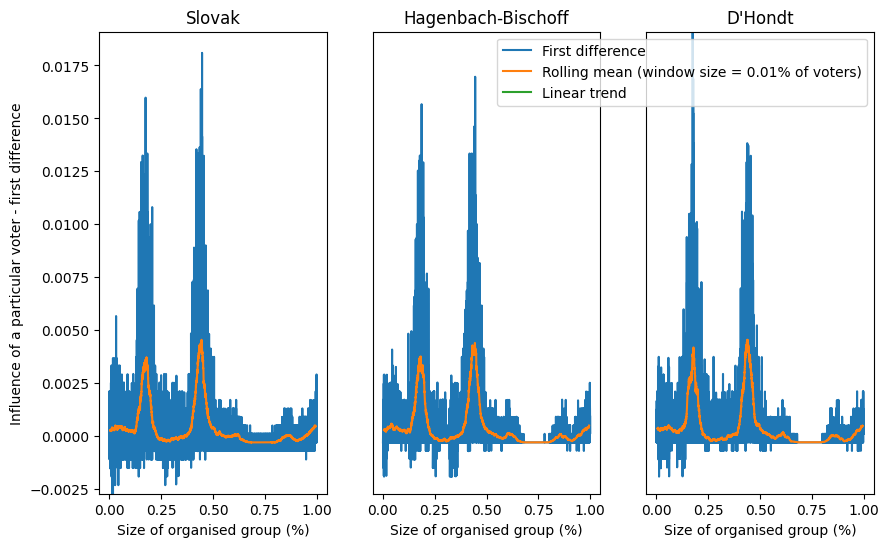

In [5]:
suffixes = ['', 'hb', 'dh']

apport_dict = {
    '' : "Slovak",
    'hb' : "Hagenbach-Bischoff",
    'dh' : "D'Hondt"
    }

fig, axes = plt.subplots(1, 3, figsize=(10, 6))

y_min = float('inf')
y_max = float('-inf')

for suffix in suffixes:
    df = pd.read_csv(f"./vis_data/electable-unweighted-vis-1m-2023{suffix}.csv")
    
    x_values = ((df['samples'] / 1000000) * (100))[:10000]
    y_values = df['diff'][:10000]
    y_vals = y_values - (3 * x_values)
    
    y_deriv = y_vals.diff()
    y_rolling = y_deriv.rolling(window=100, center=True).mean()
    
    y_min = min(y_min, y_deriv.min(), y_rolling.min())
    y_max = max(y_max, y_deriv.max(), y_rolling.max())

for i, (ax, suffix) in enumerate(zip(axes, suffixes)):
    df = pd.read_csv(f"./vis_data/electable-unweighted-vis-1m-2023{suffix}.csv")
    
    x_values = ((df['samples'] / 1000000) * (100))[:10000]
    y_values = df['diff'][:10000]
    y_vals = y_values - (3 * x_values)
    
    y_deriv = y_vals.diff()
    y_rolling = y_deriv.rolling(window=100, center=True).mean()
    
    x = np.arange(0, 1)
    y = 3 * x
    
    ax.plot(x_values, y_deriv, '-', markersize=1, label="First difference")
    ax.plot(x_values, y_rolling, '-', markersize=1, label="Rolling mean (window size = 0.01% of voters)")
    ax.plot(x, y * 0, label='Linear trend')
    
    ax.set_xlabel('Size of organised group (%)')

    ax.set_ylim(y_min, y_max)

    if suffix:
        axes[i].yaxis.set_ticks([])

    if i == 0:
        ax.set_ylabel('Influence of a particular voter - first difference')

    ax.set_title(f'{apport_dict[suffix]}')
    
    max_index = y_rolling[:3000].idxmax()
    print(f'Peek 1 location for {apport_dict[suffix]} apportionment: {int(max_index * (4388872 / 1000000))}')

    max_index = y_rolling.idxmax()
    print(f'Peek 2 location for {apport_dict[suffix]} apportionment: {int(max_index * (4388872 / 1000000))}')

plt.legend()
plt.show()


In [6]:
db_file = 'apportionments.db'

if not os.path.exists(db_file):
    suffixes = ["", "hb", "dh"]

    conn = sqlite3.connect(db_file)
    cur = conn.cursor()
            
    for suffix in suffixes:
        cur.execute(f'''CREATE TABLE IF NOT EXISTS tab{suffix} (
                    iteration_number INTEGER,
                    party_number INTEGER,
                    samples INTEGER,
                    diff INTEGER
                    );''')

        with open(f'./raw_data/1m-2023{suffix}.csv', 'r') as file:
            reader = csv.reader(file)
            next(reader)  # Skip header if exists
            for i, row in enumerate(reader):
                cur.execute(f'''INSERT INTO tab{suffix} (iteration_number, party_number, samples, diff)
                                VALUES (?, ?, ?, ?);''', row)
                
    for suffix in suffixes:
        cur.execute(f'''CREATE TABLE IF NOT EXISTS tab{suffix}coal (
                    iteration_number INTEGER,
                    party_number INTEGER,
                    samples INTEGER,
                    diff INTEGER
                    );''')

        with open(f'./raw_data/1m-2023{suffix}coal.csv', 'r') as file:
            reader = csv.reader(file)
            next(reader)  # Skip header if exists
            for i, row in enumerate(reader):
                cur.execute(f'''INSERT INTO tab{suffix}coal (iteration_number, party_number, samples, diff)
                                VALUES (?, ?, ?, ?);''', row)
            
    conn.commit()
    conn.close()

In [ ]:
'''
THIS WAS ALREADY RUN
'''

suffixes = ["", "hb", "dh"]

for suffix in suffixes:
    with sqlite3.connect('apportionments.db') as conn:
        cur = conn.cursor()

        cur.execute(f'''
            SELECT iteration_number, party_number, MIN(samples) 
            FROM tab{suffix} 
            WHERE diff < 76 
            GROUP BY iteration_number, party_number;
        ''')

        results = cur.fetchall()

        with open(f'coalitions2023{suffix}.csv', 'w', newline='') as csvfile:
            csvwriter = csv.writer(csvfile)
            csvwriter.writerow(['iteration_number', 'party_number', 'lowest_samples'])
            csvwriter.writerows(results)
        print(f'year 2023{suffix} is done')

